In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from tqdm import tqdm
import concurrent.futures

print(os.listdir())
import matplotlib.pyplot as plt

['youtube.ipynb', 'shaded.png', 'sampling_test.ipynb', 'social_to_adjacency.ipynb', '.ipynb_checkpoints', 'twitch.ipynb', 'musae_facebook_edges.csv', 'Figures', 'social_to_ds.ipynb', 'large_twitch_edges.csv', 'cleaner_algorithm.ipynb', 'nb_class_assignment.ipynb', '.DS_Store', 'artist_edges.csv']


In [2]:
parent_directory = os.path.dirname(os.getcwd())
data_directory   = os.path.join(parent_directory, "raw_datasets/facebook_large")

In [3]:
filename = "musae_facebook_edges.csv"
dataset_path = os.path.join(data_directory, filename)

social_data = pd.read_csv(dataset_path, delimiter = ",", skiprows = 0)
print(social_data.shape)
# np.savetxt(r'social_A.txt', social_data.values, fmt='%d', delimiter=",\t")
social_data.head()

(171002, 2)


,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [4]:
target_filename = "musae_facebook_target.csv"
target_path     = os.path.join(data_directory, target_filename)

target_data = pd.read_csv(target_path, delimiter = ",", skiprows = 0)
target_data.head()

node_ids = target_data["id"].tolist()
page_types = target_data["page_type"].tolist()


classes = np.unique(page_types)
int_labels = [i for i in range(classes.shape[0])]

conv_dict = {}
for i, page_type in enumerate(list(classes)):
    conv_dict[page_type] = int_labels[i]
    
print(conv_dict)

int_labels = {}

for i, item in enumerate(page_types):
    int_labels[str(i)] = conv_dict[item]

{'company': 0, 'government': 1, 'politician': 2, 'tvshow': 3}


In [5]:
import json

attribute_filename = "musae_facebook_features.json"
attribute_path     = os.path.join(data_directory, attribute_filename)

with open(attribute_path, "r") as f:
    attribute_data = json.load(f)
    
attribute_shape = len(attribute_data["15"])

keys = list(attribute_data.keys())
lengths = [len(attribute_data[l]) for l in keys]
tokens = []
for k in keys:
    tokens += attribute_data[k]
print(np.unique(lengths))
print(np.min(tokens))
print(np.max(tokens))

def feature_to_token(feature, min_t = 0, max_t = 4800):
    out_vector = np.zeros(max_t)
    out_vector[feature] = 1
    return out_vector

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 19 20 21 22 23 24 25 26 27 28 29
 30 31]
0
4713


In [6]:
columns = list(social_data.columns)
print(columns)

G = nx.from_pandas_edgelist(social_data, columns[0], columns[1], create_using = nx.Graph)

for i, node in enumerate(list(G.nodes)):
    
    G.nodes[node]["target"] = int_labels[str(node)]
    # G.nodes[node]["attribute"] = features[i,:]
    # print(features[i,:])

['id_1', 'id_2']


In [7]:
G = nx.convert_node_labels_to_integers(G)

(171002, 2)
22470
500
500


  0%|                                                                                                                  | 0/1 [00:00<?, ?it/s]

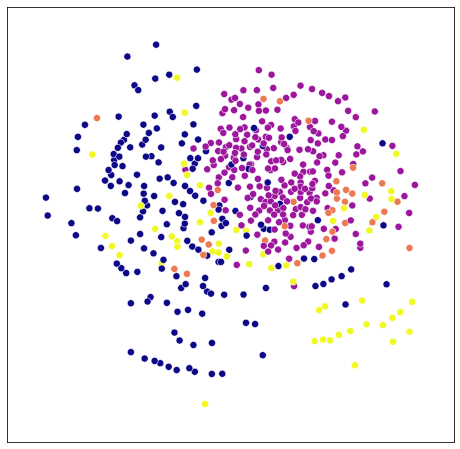

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


In [37]:
from littleballoffur import ForestFireSampler, MetropolisHastingsRandomWalkSampler, RandomWalkSampler, DiffusionSampler
print(social_data.shape)
n_nodes = np.unique(social_data.values).shape[0]
print(n_nodes)
n_graphs = 1

graph_ind_array = np.zeros(n_nodes)
min_per_graph = 499
n_per_graph = 500#int(n_nodes / n_graphs)

print(n_per_graph)

total_n = n_per_graph * n_graphs



print(total_n)
graph_ind_array = np.zeros(total_n)

graphlist = []
#number_of_nodes = int(0.5*graph.number_of_nodes())

offset_index = 0
for i in tqdm(range(n_graphs)):
    
    
    sampler = ForestFireSampler(number_of_nodes = np.random.randint(min_per_graph, n_per_graph), #n_per_graph,#
                               seed = np.random.randint(1, 1e9))
    new_graph = sampler.sample(G)
    
    # print(len(list(new_graph.nodes())))
    
    new_graph = nx.convert_node_labels_to_integers(new_graph, first_label=offset_index)
    
    graph_ind_array[offset_index:(i+1) * n_per_graph] = i+1
    
    nodes = list(new_graph.nodes())
    
    node_labels_g = [new_graph.nodes[n]["target"] for n in new_graph.nodes]
    # node_attrs_g = [new_graph.nodes[n]["attribute"] for n in new_graph.nodes]
    
    graphlist.append(new_graph)
    
    
    if i ==0:
        graph_adj = np.array(new_graph.edges())
        graph_ind_array = np.array(np.full(len(nodes), i+1))
        node_labels = np.array(node_labels_g)
        # node_attrs = np.array(node_attrs_g)
        
    else:
        graph_adj = np.append(graph_adj, np.array(new_graph.edges()), axis = 0)
        graph_ind_array = np.append(graph_ind_array, np.array(np.full(len(nodes), i+1)))
        node_labels = np.append(node_labels, node_labels_g)
        # node_attrs = np.append(node_attrs, node_attrs_g, axis = 0)
    
    if i % 50 == 0:
        # print(node_attrs.shape)
        # print(node_attrs.shape[0]/n_per_graph)
        
        fig, ax = plt.subplots(figsize = (8,8))
        
        # pos = nx.spring_layout(
        #   new_graph, k=0.1, iterations=100)
        
        pos = nx.kamada_kawai_layout(new_graph)
        
        
        colors = []
        
        for g in new_graph.nodes:
            colors.append(new_graph.nodes[g]["target"])
        
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=50,
          node_color=colors,
          alpha=1,
          linewidths=0.5,
          edgecolors = "white",
          cmap = "plasma",
          ax = ax)#,
          # font_size=1.5)
        nx.draw_networkx_edges(new_graph, pos, alpha=0.6, width=1, ax = ax, edge_color = "white", connectionstyle='arc3,rad=0.5')
        
        ax.set_facecolor('navy')

        plt.savefig(f"Figures/graph_example{i}.jpg", dpi = 400)
        plt.show()
    offset_index += len(nodes)

total_n = graph_ind_array.shape[0]

(171002, 2)
22470
250
250


  0%|                                                                                                                  | 0/1 [00:00<?, ?it/s]

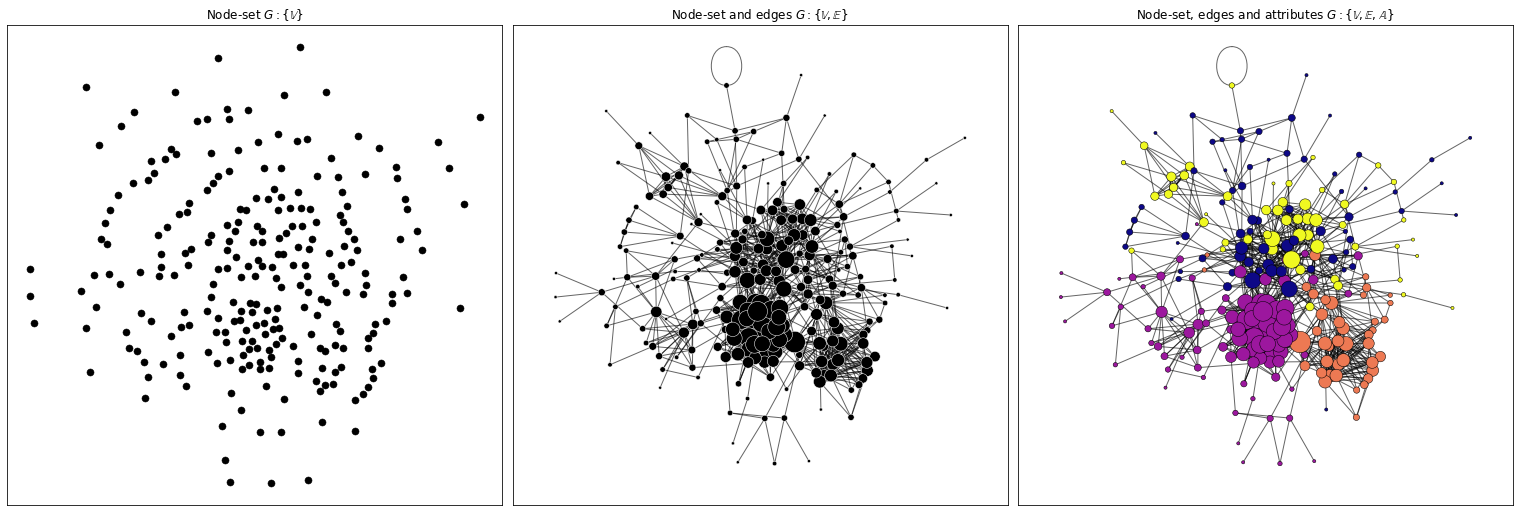

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


In [62]:
from littleballoffur import ForestFireSampler, MetropolisHastingsRandomWalkSampler, RandomWalkSampler, DiffusionSampler
print(social_data.shape)
n_nodes = np.unique(social_data.values).shape[0]
print(n_nodes)
n_graphs = 1

graph_ind_array = np.zeros(n_nodes)
min_per_graph = 249
n_per_graph = 250#int(n_nodes / n_graphs)

print(n_per_graph)

total_n = n_per_graph * n_graphs



print(total_n)
graph_ind_array = np.zeros(total_n)

graphlist = []
#number_of_nodes = int(0.5*graph.number_of_nodes())

offset_index = 0
for i in tqdm(range(n_graphs)):
    
    
    sampler = ForestFireSampler(number_of_nodes = np.random.randint(min_per_graph, n_per_graph), #n_per_graph,#
                               seed = np.random.randint(1, 1e9))
    new_graph = sampler.sample(G)
    
    # print(len(list(new_graph.nodes())))
    
    new_graph = nx.convert_node_labels_to_integers(new_graph, first_label=offset_index)
    
    graph_ind_array[offset_index:(i+1) * n_per_graph] = i+1
    
    nodes = list(new_graph.nodes())
    
    node_labels_g = [new_graph.nodes[n]["target"] for n in new_graph.nodes]
    # node_attrs_g = [new_graph.nodes[n]["attribute"] for n in new_graph.nodes]
    
    graphlist.append(new_graph)
    
    
    if i ==0:
        graph_adj = np.array(new_graph.edges())
        graph_ind_array = np.array(np.full(len(nodes), i+1))
        node_labels = np.array(node_labels_g)
        # node_attrs = np.array(node_attrs_g)
        
    else:
        graph_adj = np.append(graph_adj, np.array(new_graph.edges()), axis = 0)
        graph_ind_array = np.append(graph_ind_array, np.array(np.full(len(nodes), i+1)))
        node_labels = np.append(node_labels, node_labels_g)
        # node_attrs = np.append(node_attrs, node_attrs_g, axis = 0)
    
    if i % 50 == 0:
        # print(node_attrs.shape)
        # print(node_attrs.shape[0]/n_per_graph)
        
        fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (21,7), constrained_layout = True)
        
        # pos = nx.spring_layout(
        #   new_graph, k=0.1, iterations=50)
        
        pos = nx.kamada_kawai_layout(new_graph)
        
        
        colors = []
        
        for g in new_graph.nodes:
            colors.append(new_graph.nodes[g]["target"])
            
        sizes = []
        
        for g in new_graph.nodes:
            sizes.append(10*new_graph.degree[g])
            
            
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=50,
          node_color="black",
          alpha=1,
          linewidths=0.5,
          edgecolors = "black",
          ax = ax1)
        
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=sizes,
          node_color="black",
          alpha=1,
          linewidths=0.5,
          edgecolors = "white",
          ax = ax2)#,
          # font_size=1.5)
        nx.draw_networkx_edges(new_graph, pos, alpha=0.6, width=1, ax = ax2, edge_color = "black", connectionstyle='arc3,rad=0.5')
        
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=sizes,
          node_color=colors,
          alpha=1,
          linewidths=0.5,
          edgecolors = "black",
          cmap = "plasma",
          ax = ax3)#,
          # font_size=1.5)
        nx.draw_networkx_edges(new_graph, pos, alpha=0.6, width=1, ax = ax3, edge_color = "black", connectionstyle='arc3,rad=0.5')
        
        # ax.set_facecolor('navy')
        
        # plt.cons
        
        ax1.set_title(r"Node-set $G:\{ \mathbb{V} \}$")
        ax2.set_title(r"Node-set and edges $G:\{ \mathbb{V}, \mathbb{E} \}$")
        ax3.set_title(r"Node-set, edges and attributes $G:\{ \mathbb{V}, \mathbb{E}, \mathbb{A} \}$")

        plt.savefig(f"Figures/definitions_slide.jpg", dpi = 400)
        plt.show()
    offset_index += len(nodes)

total_n = graph_ind_array.shape[0]